# Eigenvalue problem
Eq 2 of [PRL 119, 253904 (2017)](https://doi.org/10.1103/PhysRevLett.119.253904) gives, for no magnetic field $\Omega=0$, no spin-orbit coupling $\beta=0$, no loss $\gamma=0$, no pumping $h_\pm=0$ and no non-linear terms:
$$
\frac{1}{2}\left(\partial_x^2+\partial_y^2+2ik\partial_y-k^2\right)u-\mathcal{R}u+\varepsilon u=0.
$$
Due to periodicity the correct FT of $u$ and $\mathcal{R}$ will have discrete Fourier coefficients ${u}_G$ and ${\mathcal{R}}_G$:
$$
u(x,y)=\sum_G\, u_G \,e^{i\bf{G}\cdot \bf{r}},
$$ and
$$
\mathcal{R}(x,y)=\sum_G\, \mathcal{R}_G \,e^{i\bf{G}\cdot \bf{r}},
$$ where 

$$
 G \equiv (G_x,G_y)^T \equiv \left(\frac{2\pi n}{L_x}, \frac{2\pi m}{L_y}\right)^T
$$

so that 

$$
\partial_x\xrightarrow{}{iG_x},\quad \implies \partial_x^2\xrightarrow{}{-G_x^2} \\
\partial_y\xrightarrow{}{iG_y},\quad \implies \partial_y^2\xrightarrow{}{-G_y^2}
$$

Then the equation 
$$
\frac{1}{2}\left(\partial_x^2+\partial_y^2+2ik\partial_y-k^2\right)u-\mathcal{R}u+\varepsilon u=0,
$$
becomes using the Fourier expansions of $u$ and $\mathcal{R}$
$$
\sum_G\frac{1}{2}\left(-G_x^2-G_y^2-2kG_y-k^2\right)u_Ge^{iG\cdot r}-\sum_{GG'}\mathcal{R}_{G'}u_Ge^{i(G'+G)\cdot r}=-\varepsilon \sum_G u_G e^{iG\cdot r}.
$$
Moving the indices in double sum several times we realise that it is the same as:
$$
\sum_{GG'}\mathcal{R}_{G'}u_Ge^{i(G'+G)\cdot r}=\sum_{GG'}\mathcal{R}_{G-G'}u_{G'}e^{iG\cdot r}
$$

giving us an eigenvalue equation over the basis $e^{iG\cdot r}$:
$$
\frac{1}{2}\left(G_x^2+(k+G_y)^2\right)u_G+\sum_{G'}\mathcal{R}_{G-G'}u_{G'}=\varepsilon\,u_G
$$

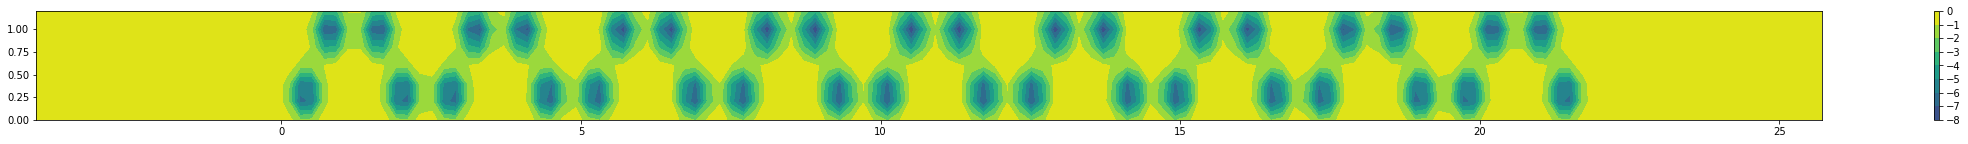

In [14]:
#constructing R function for lattice of gaussians

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator

# PRL 119, 253904 (2017)
#https://doi.org/10.1103/PhysRevLett.119.253904

a = 1.4 #lattice constant
b = a/np.sqrt(3)
uc_pillars = [(0,0),       (0.5*b, 0.5*np.sqrt(3)*b), 
             (1.5*b,0.5*np.sqrt(3)*b), (2*b,0)] 
             #4 pillars' coordinates in the rectangular unit cell
cell_width = np.sqrt(3)*a
cell_height = a

def principaly(y):
    return np.abs(cell_height*(y/cell_height-np.floor(y/cell_height)))

def pillar(coord,pillarindex):
    x,y = coord
    i,j = pillarindex
    ym = j*cell_height + uc_pillars[i%4][1]             + a/np.sqrt(24)
    xm = np.floor(i/4)*cell_width + uc_pillars[i%4][0]  + a/np.sqrt(12)
    
    p=8
    d=.25
    return -p*np.exp(-((x-xm)**2+(y-ym)**2)/d**2)

def R(x,y):
    x += cell_width*9/2
    # y += cell_height/2
    total = np.zeros_like(x)
    y = principaly(y)
    for i in np.arange(0,len(uc_pillars)*9):
        total += pillar( (x,y) , pillarindex=(i,0) )
    return total

x_ = np.arange(-15, 15, 0.2)
y_ = np.arange(0, cell_height, 0.2)
x_, y_ = np.meshgrid(x_, y_)

r_ = R(x_,y_)

plt.figure(figsize=(40,2))
h = plt.contourf(x_, y_, r_)

plt.colorbar()
plt.clim(-10,0)
plt.show()

trapztest:  (-12.044254214192108+40.715782110125105j)
test harmonics
<function R at 0x000002691C0303A0>


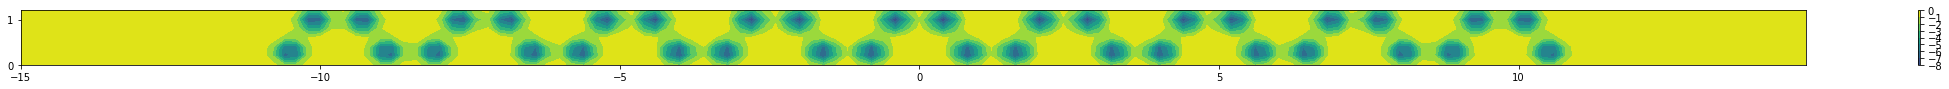

calculating R harmonics...done!


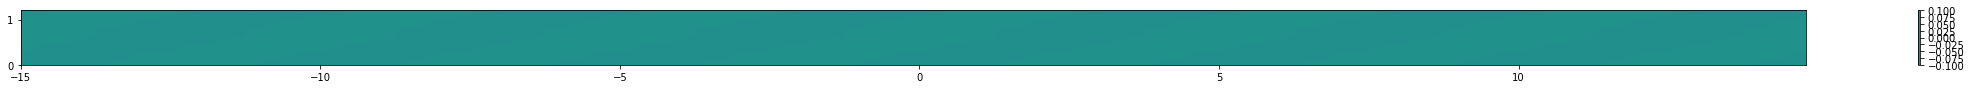

(10,)
(10,)


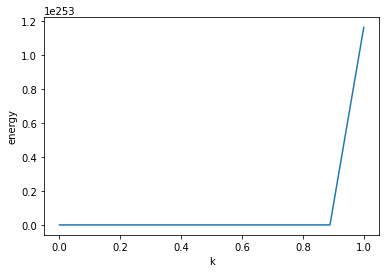

In [20]:
# Code for above eigen value equation:
import numpy as np
from scipy import integrate
import numpy.linalg as la

def generate_basis(N:int, M:int):
    """
    Generates an ordered basis, that is, an np array of tuples containing Bragg harmonics indicies in a particular order to be used to generate matrices for secular eqations.
    
    Returns
    -------
    A np array of tuples of 2 ints. The first int is Bragg harmonic index in N direction. The second in M direction.
    """
    # Assume that their are N fourier harmonics in the x direction and M along y
    n_ = np.arange(-N,N+1)
    m_ = np.arange(-M,M+1)
    # Then we choose to order the harmonics of u_G as a sum over n of sum over m
    basis = np.empty(len(n_)*len(m_),dtype=tuple)
    for i,n in enumerate(n_):
        for j,m in enumerate(m_):
            basis[i*len(m_)+j]=(n,m)
    return basis
basis = generate_basis(N=4,M=3)
# print(basis)

def build_matrix(basis, entry_formula:callable):
    size = len(basis)
    matrix = np.empty([size,size],dtype=complex)
    for i in np.arange(0,size):
        for j in np.arange(0,size):
            row = basis[i]
            col = basis[j]
            matrix[i][j] = entry_formula(row, col)
    return matrix

# def trapz2d(func, fromx,tox,fromy,toy, dx=.2, dy=.2):
#     nx = int((tox - fromx) / dx)
#     ny = int((toy - fromy) / dy)
#     x_, y_ = np.meshgrid(np.linspace(fromx, tox, nx, endpoint=False),
#                          np.linspace(fromy, toy, ny, endpoint=False),
#                          indexing='ij')
#     vfunc = np.vectorize(func)
#     r_ = vfunc(x_,y_)
#     int_along_x = np.trapz(r_, axis=1, dx=dx)
#     int_total = np.trapz(int_along_x, dx=dy)
#     return int_total

print("trapztest: ", trapz2d(lambda x,y: R(x,y)*np.exp(5j),0,5,0,5))

def G(diff_coord):
    n,m = diff_coord
    return np.array([2*np.pi*n/Lx,2*np.pi*m/Ly])

def calculate_R_harmonics(N,M, R:callable):
    print("calculating R harmonics...",end="")
    dx = .2
    dy = .2
    fromx=-Lx/2
    tox=Lx/2
    fromy=-Ly/2
    toy=Ly/2
    nx = int((tox - fromx) / dx)
    ny = int((toy - fromy) / dy)
    x_, y_ = np.meshgrid(np.linspace(fromx, tox, nx, endpoint=False),
                         np.linspace(fromy, toy, ny, endpoint=False),
                         indexing='ij')
    vR = np.vectorize(R)
    
    # The harmonics are going to range from -2N:2N and -2M:2M
    R_harmonics = np.empty([4*N+1,4*M+1], dtype=complex)
    for i,row in enumerate(R_harmonics):
        for j,entry in enumerate(row):
            n = i-2*N
            m = j-2*M
            # R_harmonics[i][j] = trapz2d(lambda x,y: R(x,y)*np.exp(-1j*np.dot(G((n,m)),[x,y])), -Lx/2,Lx/2,-Ly/2,Ly/2)
            Gx,Gy=G((n,m))
            basis = np.exp(-1j * (Gx*x_ + Gy*y_))
            r_ = R(x_,y_)*basis
            int_along_x = np.trapz(r_, axis=1, dx=dx)
            int_total = np.trapz(int_along_x, dx=dy)
            R_harmonics[i][j] = int_total
    print("done!")
    return R_harmonics/Lx/Ly


def fetch_R_harmonic(n,m,R_harmonics):
    rows,cols = R_harmonics.shape
    N=int((rows-1)/4)
    M = int((cols-1)/4)
    return R_harmonics[n+2*N][m+2*M]

# print(fetch_R_harmonic(-8,2,R_harmonics))



Lx = 30
Ly = cell_height

def test_T_harmonics():
    #have a sample function, and test whether calculate_R_harmonics function is behaving properly
    print("test harmonics")
    print(R)
    vR = np.vectorize(R)
    x_ = np.arange(-15, 15, 0.2)
    y_ = np.arange(0, cell_height, 0.2)
    x_, y_ = np.meshgrid(x_, y_)
    
    r_ = vR(x_,y_)

    plt.figure(figsize=(40,1))
    h = plt.contourf(x_, y_, r_)

    plt.colorbar()
    plt.clim(-10,0)
    plt.show()
    
    N=3
    M=3
    
    harmonics = calculate_R_harmonics(N,M, R)
    
#     plt.figure(figsize=(40,1))
#     h = plt.imshow(np.real(harmonics))
    
    
    x_ = np.arange(-15, 15, 0.2)
    y_ = np.arange(0, cell_height, 0.2)
    x_, y_ = np.meshgrid(x_, y_)
    
    # G_ij = np.empty([4*N+1, 4*M+1],dtype=complex)
    
    def rebuild_func(x,y):
        total = 0j
        for i, row in enumerate(harmonics):
            for j,_ in enumerate(row):
                n = i-2*N
                m = j-2*M
                total += fetch_R_harmonic(n,m, harmonics) * np.exp( 1j*np.dot( G((n,m)), [x,y] ) )
        return total
    vrebuild_func = np.vectorize(rebuild_func)
    rr_ = vrebuild_func(x_,y_)
    plt.figure(figsize=(40,1))
    h = plt.contourf(x_, y_, rr_)

    plt.colorbar()
    plt.clim(-10,10)
    plt.show()

test_T_harmonics()
    


def hamiltonian_formula(row,col,k):
    diag_term = 0
    if row==col:
        Gx,Gy = G(row)
        diag_term = .5*(Gx**2+(k+Gy)**2)
    n,m = tuple(np.subtract(row,col))
    return diag_term + fetch_R_harmonic(n,m,R_harmonics)

def calc_eig(k):
    hamiltonian = build_matrix(basis, entry_formula = lambda row,col: hamiltonian_formula(row,col,k))
    eigval,eigvec = la.eig(hamiltonian)
    return eigval

# R_harmonics = calculate_R_harmonics(4,3,lambda x,y: x+y)
# print(R_harmonics)
Lx = 1
Ly = 1
N=4
M=3
k_ = np.linspace(0,1,10)
eps__ = np.empty([len(k_),(2*N+1)*(2*M+1)],dtype=complex)

print(k_.shape)
print(np.transpose(eps__)[0].shape)

# for i,k in enumerate(k_):
#     eps_ = calc_eig(k)
#     eps__[i] = np.sort_complex(eps_)

import matplotlib.pyplot as plt
plt.plot(k_,np.real(np.transpose(eps__)[31]))
plt.ylabel('energy')
plt.xlabel('k')
plt.show()

